# Experiment logs

In [25]:
import os

logsdir = './logs'

#results storage
less_than_three = [] #participants who succeeded less than 3/5 times
total_tasks = 0
total_errors = 0
system_failures = 0

#loop through files
for filename in os.listdir(logsdir):
    with open(logsdir + '/' + filename, 'r') as file:
        #read file
        lines = [line.strip() for line in file.readlines()]
        
        #read headers at top
        extract_info = lambda index : lines[index].split()[-1]
        participant_id = extract_info(0)
        condition = int(extract_info(1))
        successes = int(extract_info(2))
        
        if successes < 3:
            less_than_three.append((participant_id, condition))
        
        #report on system failures
        total_tasks += 5
        total_errors += 5 - successes 
            
        if successes < 5:
            for i, line in enumerate(lines):
                if line.startswith('ERROR'):
                    task_succeeded = extract_info(i-1) == 'yes'
                    error_raised = extract_info(i)
                    if error_raised == 'True' and not task_succeeded:
                        system_failures += 1

In [27]:
print(len(less_than_three))
print(total_tasks)
print(system_failures)

1
40
6


# User Evaluations

## Import evaluation data

In [30]:
import numpy as np
import csv

In [31]:
#links questions to their topic and whether they are positive (True) or negative (False)

question_to_topic = { 1 : ('clarity', False), 
                      2 : ('usability', True),
                      3 : ('accuracy', True),
                      4 : ('clarity', False),
                      5 : ('clarity', True),
                      6 : ('brevity', True),
                      7 : ('affect', False),
                      8 : ('accuracy', False),
                      9 : ('usability', False),
                      10 : ('affect', True),
                      11 : ('brevity', False),
                      12 : ('usability', False),
                      13 : ('brevity', False),
                      14 : ('usability', True),
                      15 : ('affect', True),
                      16 : ('clarity', True),
                      17 : ('accuracy', False),
                      18 : ('affect', False),
                      19 : ('brevity', True),
                      20 : ('accuracy', True)
                    }

In [32]:
#import data from csv

topics = ['accuracy', 'affect', 'brevity',  'clarity', 'usability', 'total']

responses_test = {topic: [] for topic in topics}
responses_control = {topic: [] for topic in topics}

with open('responses.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        if len(row[1]) == 3:
            ID = int(row[1])
            condition = ID % 2
            
            for i in range(20):
                topic, positive = question_to_topic[i + 1]
                rating = int(row[5 + i])
                
                if not positive:
                    rating = 6 - rating
                
                if condition == 1:
                    responses_test[topic].append(rating)
                    responses_test['total'].append(rating)
                else:
                    responses_control[topic].append(rating)
                    responses_control['total'].append(rating)

## Make histograms

In [33]:
from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = [10.0, 8.0]

rcParams['font.size'] = 12
rcParams['font.family'] = 'sans-serif'

In [34]:
def histogram(topic, condition, make_title = True, title = '', exportpath = None):
    """Make a plot of the responses for a particular topic and condition"""
    categories = np.arange(5) + 1

    def count(cat, responses):
        return len([x for x in responses if x == cat])

    with plt.style.context('seaborn-paper'):
        if condition == 'test':
            plt.bar(categories, [count(cat, responses_test[topic]) for cat in categories])
        else:
            plt.bar(categories, [count(cat, responses_control[topic]) for cat in categories])
        plt.xlabel('response')
        plt.ylabel('frequency')
        
        if make_title:
            if title == '':
                title = 'Distribution of responses regarding ' + topic + ' in ' + condition + ' condition'
            plt.title(title)
        
        if exportpath:
            plt.savefig(exportpath + '.pdf')

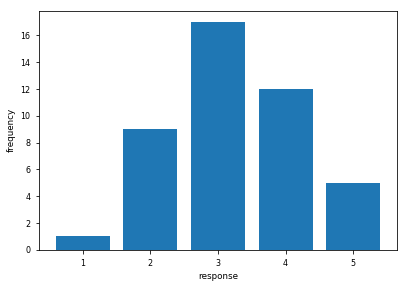

In [36]:
#example
histogram('clarity', 'test', make_title = False)

### Save figures

In [21]:
conditions = [('a', 'test'), ('b', 'control')]

starting_index = 3

for i, topic in enumerate(topics):
    for sub_i, condition in conditions:
        index = str(i + starting_index) + sub_i
        filename =  ' '.join([index, topic, condition])
        
        histogram(topic, condition, make_title = False, exportpath = filename)
        plt.close()

## Test significance

In [37]:
import scipy.stats as stats

In [43]:
#count frequencies
def frequencies(responses):
    get_freq = lambda rating : sum(int(response == rating) for response in responses)
    freqs = [get_freq(i + 1) for i in range(5)]
    
    return freqs

#perform chi-squared
def compare(topic):
    control = frequencies(responses_control[topic])
    test = frequencies(responses_test[topic])
    
    chi, p = stats.chisquare(test, control)
    
    return chi, p

In [49]:
for topic in topics:
    chi, p = compare(topic)
    
    chi = round(chi, 2)
    p = round(p, 3)
    
    print(topic, chi, p)

accuracy 3.91 0.419
affect 6.19 0.186
brevity 3.58 0.466
clarity 4.12 0.39
usability 13.3 0.01
total 1.71 0.79


In [68]:
#compute the median for usability
def over_n(n):
    get_ratio = lambda responses : round( sum(int(response >= n) for response in responses) / len(responses), 3 )
    
    print('test:', get_ratio(responses_test['usability']))
    print('control:', get_ratio(responses_control['usability']))

def quantile(q):
    quantile_test = np.nanquantile(responses_test['usability'], q)
    quantile_control = np.nanquantile(responses_control['usability'], q)

    print('test:', quantile_test)
    print('control:', quantile_control)


over_n(4)


test: 0.477
control: 0.318
